# AMLB Visualizations
This notebook contains code to generate critical difference diagrams (Figure 2) from the paper "AMLB: an AutoML Benchmark" by Gijsbers et al. (2022). As input, it assumes "cleaned logs" which are available at `http://openml-test.win.tue.nl/amlb/*_cleaned.csv` and the `CleanResults` notebook shows how they are constructed from the raw results. 

The `orange` dependency for CD plots can be problematic with (some?) Windows setups, but it is possible to install only a few of `orange`'s dependencies to make it work. It might help first installing the latest version of `Orange3` and then downgrading with `python -m pip install "Orange3==3.30.0" --no-deps`.

In [8]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import Orange

from data_processing import get_print_friendly_name, impute_results, calculate_ranks, is_old

In [9]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "CD"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [10]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results = results[~results["framework"].isin(["NaiveAutoML", "autosklearn2"])]
results["framework"] = results["framework"].apply(get_print_friendly_name)

## Imputation of Missing Values
Sometimes frameworks do not finish. This can have various reasons such as violating time or memory constraints, or simple bugs in the software (cf. error visualization). As a rule, we impute these missing values with results of the `constantpredictor`. Our reasoning is detailed in the paper, but the short version is this: errors are often correlated with "dataset difficulty" and thus can not be simply ignored. Since we expect AutoML frameworks to have a reasonable fallback (such as random forest), and it takes effort and time to ensure this, we can not impute with such a baseline. The `constantpredictor` imputation is harsh, be we found it most fair.

In [11]:
results = impute_results(
    results,
    where=results["result"].isna(),
    with_="constantpredictor",
)

In our paper, we make one exception to this: there is one specific bug that affected 72 (of 1040) runs of AutoGluon(HQIL) specifically. This bug has been confirmed to be resolved in AutoGluon 0.8.3 (we benchmarked 0.8.0). Based on experiments, we can say with great confidence that the AutoGluon(HQIL) performance in 0.8.3 closely matches the AutoGluon(HQ) performance of 0.8.0. To better represent the AutoGluon(HQIL)'s performance, we chose to impute these specific missing values with AutoGluon(HQ) results. Missing results for AutoGluon(HQIL) that are not caused by this bug will be imputed with `constantpredictor` as usual.

In [12]:
# The AutoGluon(HQIL) can be uniquely recognized by the "'NoneType' object has no attribute 'name'" error message.
autogluon_bug = results["info"].apply(lambda v: isinstance(v, str) and "'NoneType' object has no attribute 'name'" in v)
results = impute_results(
    results,
    where=autogluon_bug,
    with_="AutoGluon(HQ)",
)

# CD Plots
Figure 2 in the paper. To get the true figures from the paper, where `TunedRandomForest` is not cut off from the figure, you need to modify the `Orange.evaluation.scoring:graph_ranks` method and add `return fig` at the end of it. This file is probably located in your virtual environment: `venv/lib/python3.9/site-packages/Orange/evaluation/scoring.py`, and the `graph_ranks` function is at the end of the file.

In [13]:
def plot_cd(results, filename=None):
    ranks = calculate_ranks(results)
    n_tasks = results["task"].nunique()
    critical_difference = Orange.evaluation.compute_CD(ranks.values(), n_tasks)
    fig = Orange.evaluation.graph_ranks(
        ranks.values(),
        list(ranks),
        cd=critical_difference,
        width=6,
        textspace=1.5,
        filename=filename
    )
    if not fig:
        plt.title(filename.name)
    else:
        # If you patched orange, we instead save to file with the following method,
        # this prevents the `TunedRandomForest` name from being cut off from the figure.
        with PdfPages(filename) as f:
            f.savefig(fig, bbox_inches="tight")

generating cd-multiclass-classification-1h8c_gp3-constantpredictor.pdf
generating cd-binary-classification-1h8c_gp3-constantpredictor.pdf
generating cd-regression-1h8c_gp3-constantpredictor.pdf
generating cd-multiclass-classification-4h8c_gp3-constantpredictor.pdf
generating cd-binary-classification-4h8c_gp3-constantpredictor.pdf
generating cd-regression-4h8c_gp3-constantpredictor.pdf


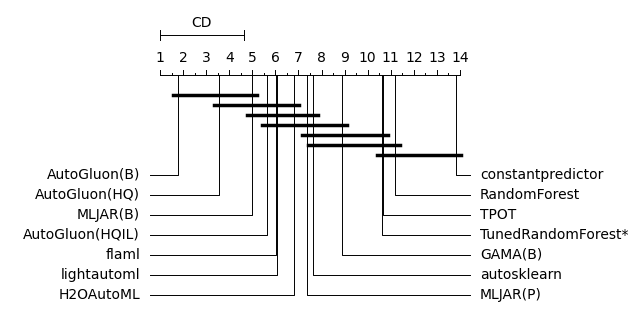

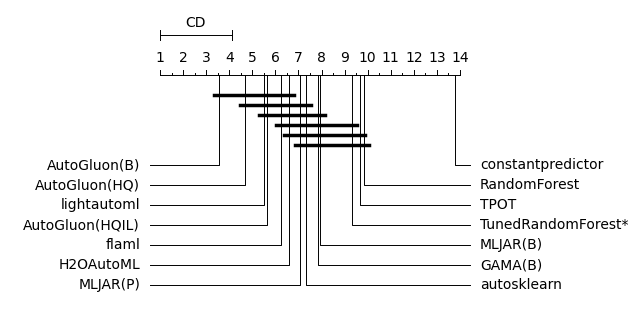

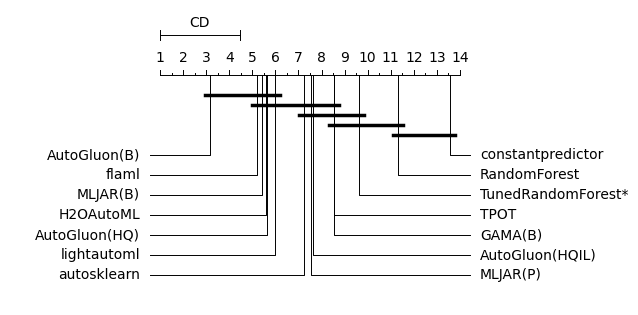

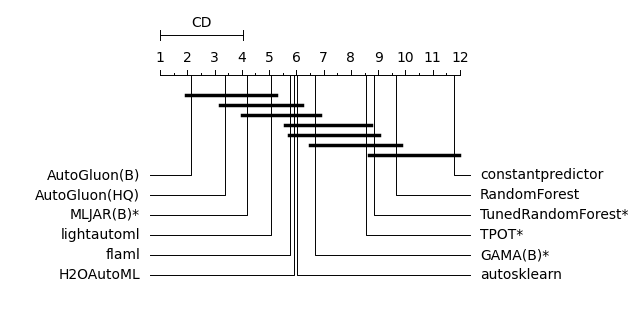

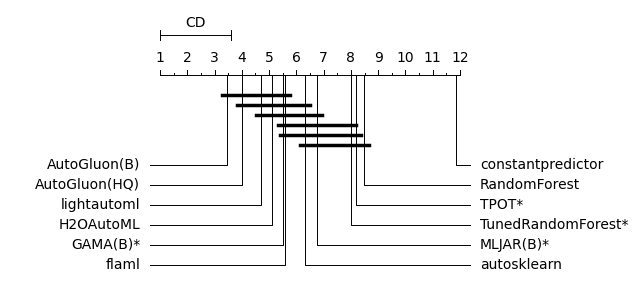

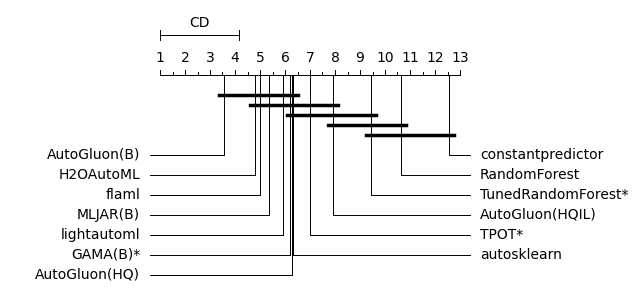

In [14]:
for constraint, metric in itertools.product(results.constraint.unique(), results.metric.unique()):    
    data = results[(results["constraint"] == constraint) & (results["metric"] == metric)].copy()
    data["framework"] = data["framework"].apply(lambda name: f'{name}*' if is_old(name, constraint, metric) else name)
    ttype = {"neg_rmse": "regression", "auc": "binary classification", "neg_logloss": "multiclass classification"}[metric]
    # We exclude autosklearn2 because the metadataset overlaps with the benchmark
    data = data[data["framework"] != "autosklearn2"]
    
    filename = f"cd-{ttype.replace(' ','-')}-{constraint}-constantpredictor.pdf"
    print("generating", filename)
    plot_cd(data, filename=FIGURE_DIRECTORY / filename)

generating cd-all-1h8c_gp3-constantpredictor.pdf
generating cd-all-4h8c_gp3-constantpredictor.pdf


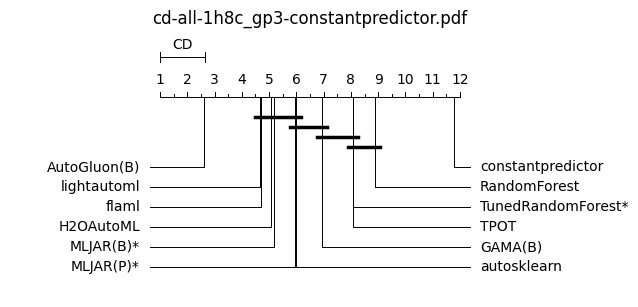

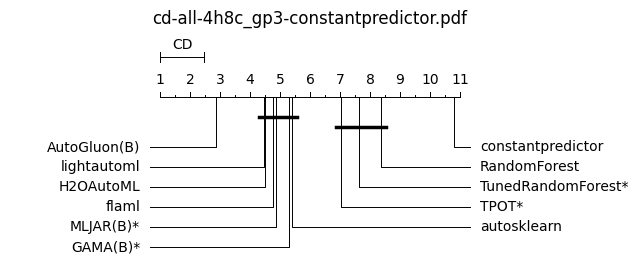

In [12]:
for constraint in ["1h8c_gp3", "4h8c_gp3"]:
    data = results[(results["constraint"] == constraint)].copy()
    data["framework"] = data.apply(
        lambda row: f'{row["framework"]}*' if is_old(row["framework"], constraint, row["metric"]) or "MLJAR" in row["framework"] else row["framework"], 
        axis=1
    )
    ttype = "all"
    # We exclude autosklearn2 because the metadataset overlaps with the benchmark,
    # we also exclude frameworks where do not have any 4 hour results.
    data = data[~data["framework"].isin(["autosklearn2", "AutoGluon(HQ)", "AutoGluon(HQIL)"])]
    
    filename = f"cd-{ttype}-{constraint}-constantpredictor.pdf"
    print("generating", filename)
    plot_cd(data, filename=FIGURE_DIRECTORY / filename)